In [20]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [21]:
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.compat.v2.config.experimental.set_memory_growth(gpu, True)
    
import math
import keras
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_blazeface import blazeface
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxesBlazeFace import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from ssd_encoder_decoder.ssd_input_encoder_blazeface import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder_blazeface import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize

%matplotlib inline

In [22]:
# Set the image size.
img_height = 256
img_width = 256

In [23]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = blazeface(image_size=(img_height, img_width, 3),
                n_classes=1,
                mode='inference',
                l2_regularization=0.0005,
                scales=[[0.2]], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0]],
                steps=[64],
                offsets=None,
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[107, 105, 109],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.1,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'checkpoint/blazeface_with_26landmark_without_box_epoch-76_loss-7244.8734.h5'

# model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [24]:
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
identity_layer (Lambda)      (None, 256, 256, 3)       0         
_________________________________________________________________
input_mean_normalization (La (None, 256, 256, 3)       0         
_________________________________________________________________
input_channel_swap (Lambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
model_1 (Model)              (None, 8, 8, 96)          74496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 52)          44980     
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 52)          0   

In [25]:
train_images_dir = "/data/"
train_anno_file = "/data/tsmoon_set/train_with_box.csv"

train_dataset = DataGenerator(load_images_into_memory=None, hdf5_dataset_path=None,fix_image_ratio=True)

# Ground truth
train_labels_filename = train_anno_file


train_dataset.parse_csv(images_dir=train_images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name','xmin','ymin','xmax', 'ymax', 'kp1_x','kp1_y','kp2_x','kp2_y','kp3_x','kp3_y','kp4_x','kp4_y','kp5_x','kp5_y',
                                           'kp6_x','kp6_y','kp7_x','kp7_y','kp8_x','kp8_y','kp9_x','kp9_y','kp10_x','kp10_y','kp11_x','kp11_y','kp12_x','kp12_y','kp13_x',
                                           'kp13_y','kp14_x','kp14_y','kp15_x','kp15_y','kp16_x','kp16_y','kp17_x','kp17_y','kp18_x','kp18_y','kp19_x','kp19_y','kp20_x','kp20_y','kp21_x',
                                           'kp21_y','kp22_x','kp22_y','kp23_x','kp23_y','kp24_x','kp24_y','kp25_x','kp25_y','kp26_x','kp26_y','class_id'],
                        include_classes='all')

In [26]:
batch_size = 32
predictor_sizes = np.array([16,16])
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales = [[0.2]]
aspect_ratios = [[1.0]] # The anchor box aspect ratios
steps = [64] # The space between two adjacent anchor box center points for each predictor layer.
offsets = None # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color,
                                           fix_image_ratio=True)
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)


ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

train_generator = train_dataset.generate(batch_size=batch_size,
                                        shuffle=True,
                                        transformations=[ssd_data_augmentation],
                                        label_encoder=ssd_input_encoder,
                                        returns={'processed_images',
                                                'encoded_labels',
                                                'filenames'},
                                        keep_images_without_gt=normalize_coords)

In [27]:
a = next(train_generator)

In [28]:
print("model output shape :", a[1].shape)
print("input image shape : ", a[0].shape)
print("data file name : ", a[2][0])

model output shape : (32, 1, 104)
input image shape :  (32, 256, 256, 3)
data file name :  /data/Korea_Female_1/20200903_day_sun_03/Class_5-1/frame/4_20200903_day_sun_03/4_20200903_day_sun_03_2 07.jpg


In [29]:
confidence_thresh=0.01
iou_threshold=0.45
nms_max_output_size=400
normalize_coords=True
coords='centroids'
top_k = 200
decoded_predictions = DecodeDetections(confidence_thresh=confidence_thresh,
                                                   iou_threshold=iou_threshold,
                                                   top_k=top_k,
                                                   nms_max_output_size=nms_max_output_size,
                                                   coords=coords,
                                                   normalize_coords=normalize_coords,
                                                   img_height=img_height,
                                                   img_width=img_width,
                                                   name='decoded_predictions')


In [30]:
y_pred = tf.convert_to_tensor(a[1])
y_pred = tf.cast(y_pred,tf.float32)
output = decoded_predictions.call(y_pred)

In [31]:
output[0][0]

<tf.Tensor: shape=(52,), dtype=float32, numpy=
array([ -28.79,  -58.17, -132.79,  -51.76,  -18.42,    2.78,  -18.09,
         -2.24,  -19.78,   11.96,  -18.1 ,   11.39,  -13.38,   -6.54,
        -11.29,   -6.99,   -8.44,   14.11,   -2.68,   -3.68,  -11.73,
          9.47,   -8.74,    2.42,  -14.96,   10.99,  -11.17,   10.76,
        -10.26,   -3.55,   -6.62,   -1.29,  -15.18,    9.48,  -11.79,
         -1.28,  -29.51,    4.74,  -19.61,    2.95,  -10.79,    9.96,
         -0.33,    1.71,  -16.3 ,    1.97,  -13.71,    3.77,  -13.11,
          0.65,   -9.78,    4.09], dtype=float32)>

In [32]:
anchor = [ float(x) for x in open('anchor_256_fix.txt').readline().split(',') if x != '']

In [33]:
output = np.add(y_pred[0,0,:52], anchor)

In [34]:
output

array([ 80.67753906,  78.94277344, 184.27128909,  72.55781251,
       124.34804687,  77.23085937, 152.01933594,  76.23125   ,
       101.70273437,  70.08671875, 102.02929687,  77.65449219,
       169.32773437,  69.51445313, 170.24589844,  76.96269531,
        89.40703125,  98.94511719, 177.66953125,  95.665625  ,
       116.68417969,  98.56699219, 153.70585938,  97.58945313,
       103.9015625 ,  94.05292969, 104.12636719, 102.28203125,
       167.21992187,  92.53613281, 167.59414063, 100.28496094,
       124.12070312, 141.55703125, 162.74394531, 140.275     ,
       151.39472656, 134.27851562, 146.53339844, 147.06152344,
       118.74785156, 180.07890625, 166.32871094, 177.29667969,
       148.23632813, 167.03769531, 147.65644531, 174.24472656,
       147.05878906, 179.35253906, 147.74179688, 188.92597656])

In [35]:
dbset = [9,11,13,14,21,23,24,25,26]
output_index = []
for i in dbset:
    output_index.append(i*2-2)
    output_index.append(i*2-1)
output = output[output_index]

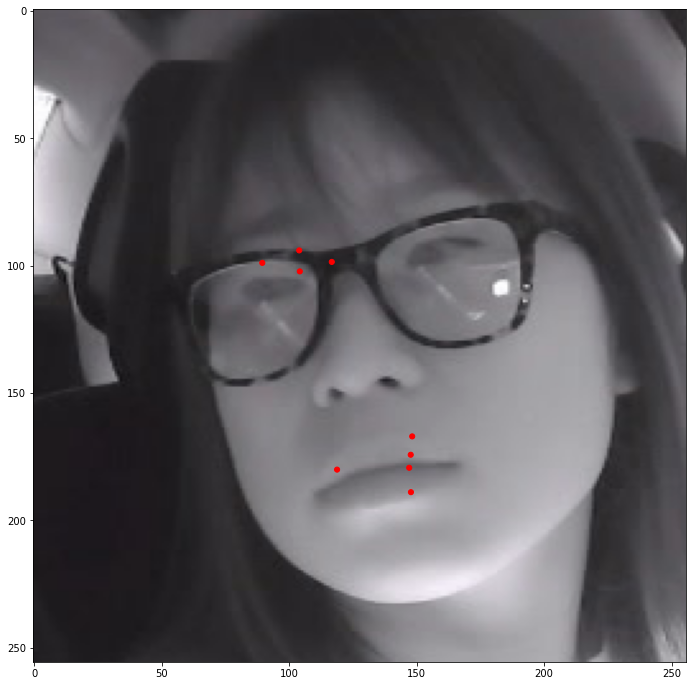

In [36]:
# Display the image and draw the predicted boxes onto it.
from PIL import Image
# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'face']

plt.figure(figsize=(20,12))
# plt.imshow(orig_images[0])

plt.imshow(Image.fromarray(a[0][0]))

current_axis = plt.gca()
# print(orig_images[0].shape[1])
# print(orig_images[0].shape[0])
# box = y_pred_thresh[][12]
box = output



color = colors[0]
#     label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
#     current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  

for i in range(0,len(output), 2):
    current_axis.add_patch(plt.Circle((box[i], box[i+1]), 1, color=color))
    
# for box in y_pred_thresh[1]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.

    
    
#     color = colors[int(box[0])]
#     label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
#     current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  


#     label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
#     current_axis.text(xmin, ymin, '', size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})